Dataset can be downloaded at : https://www.kaggle.com/c/nlp-getting-started/data

In this tutorial, we are going to download from https://github.com/zaemyung/disaster_tweets (see below)

You are **predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0**. You’ll have access to a dataset of 10,000 tweets that were hand classified.
Each sample in the train and test set has the following information:

1. A keyword from that tweet (although this may be blank!)
2. The location the tweet was sent from (may also be blank)
3. The text of a tweet

PS: this notebook has been adapted from previous semesters' tutorials

In [80]:
! pip install -U -q torch
! pip install -q sentencepiece

In [81]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
import sentencepiece as spm
import statistics as stats

import re
import string
import time
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [82]:
torch.__version__

'2.5.1+cu121'

In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

### Loading the dataset ###

In [84]:
train_df = pd.read_csv("https://raw.githubusercontent.com/zaemyung/disaster_tweets/main/Disaster%20Tweets/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/zaemyung/disaster_tweets/main/Disaster%20Tweets/test.csv")

In [85]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [86]:
train_df.shape

(7613, 5)

In [87]:
test_df.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [88]:
test_df.shape

(3263, 4)

In [89]:
train_df.head()  # prints the first five instances. c.f., .tail()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


What does a disaster tweet look like ?

In [90]:
train_df[train_df["target"] == 1]["text"].values[30]

'Reported motor vehicle accident in Curry on Herman Rd near Stephenson involving an overturned vehicle. Please use... http://t.co/YbJezKuRW1'

What does a non-disaster tweet look like ?

In [91]:
train_df[train_df["target"] == 0]["text"].values[3]

'My car is so fast'

Is dataset balanced or imbalanced ?
Removing special tweet specific symbols

In [92]:
balance_counts = train_df.groupby('target')['target'].agg('count')
balance_counts # nearly equal!

,target
target,
0,4342
1,3271


### Text Cleaning ###

In [93]:
#Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [94]:
train_df['text_clean'] = train_df['text'].apply(clean_text)
train_df.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [95]:
test_df['text_clean'] = test_df['text'].apply(clean_text)
test_df.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan


### Create vocabs using Byte-Pair Encoding (BPE) tokenization
BPE tokenization, inspired by data compression, works by iteratively merging the most frequent pairs of characters in a text corpus until a predefined vocabulary size is reached.

In [96]:
!mkdir preprocessed_data
# save the cleaned texts as a plain file which is going to be the input for learning BPE tokenization
with open('preprocessed_data/train.text', 'w') as f:
  for text in train_df['text_clean']:
    f.write(f'{text.strip()}\n')

mkdir: cannot create directory ‘preprocessed_data’: File exists


In [97]:
VOCAB_SIZE = 8000

In [98]:
# learn a BPE tokenization model
spm.SentencePieceTrainer.train(input='preprocessed_data/train.text', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

In [99]:
sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

def tokenize_into_str(text):
  return ' '.join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
  return ' '.join([str(tok) for tok in sp.encode(text)])

In [100]:
train_df['text_tokenized'] = train_df['text_clean'].apply(tokenize_into_str)
train_df['text_indices'] = train_df['text_clean'].apply(tokenize_into_idx)
train_df['text_indices'] = train_df['text_indices'].replace('', np.nan)
train_df.dropna(subset=['text_indices'], inplace=True)
train_df.head()

,id,keyword,location,text,target,text_clean,text_tokenized,text_indices
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,▁our ▁de eds ▁are ▁the ▁reason ▁of ▁this ▁eart...,557 98 2285 148 26 2266 44 147 1085 415 4057 2...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,▁forest ▁fire ▁near ▁la ▁r ong e ▁s as k ▁canada,820 167 542 1089 67 298 7969 6 45 7989 3355
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,▁all ▁residents ▁asked ▁to ▁shelter ▁in ▁place...,219 4193 3753 38 5030 34 1906 148 641 186 2109...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,▁people ▁rece ive ▁wildfires ▁evacuation ▁orde...,325 5444 280 3406 1086 3364 34 494
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,▁just ▁got ▁sent ▁this ▁photo ▁from ▁rub y ▁al...,197 439 2248 147 1290 162 1282 7986 4455 140 1...


In [101]:
test_df['text_tokenized'] = test_df['text_clean'].apply(tokenize_into_str)
test_df['text_indices'] = test_df['text_clean'].apply(tokenize_into_idx)
test_df['text_indices'] = test_df['text_indices'].replace('', np.nan)
test_df.dropna(subset=['text_indices'], inplace=True)
test_df.head()

,id,keyword,location,text,text_clean,text_tokenized,text_indices
0,0,NaN,NaN,Just happened a terrible car crash,just happened a terrible car crash,▁just ▁happened ▁a ▁terrible ▁car ▁crash,197 2366 4 4561 350 369
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...,▁heard ▁about ▁earthquake ▁is ▁different ▁citi...,1503 300 1085 70 2776 5587 1704 4032 1016
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,▁there ▁is ▁a ▁forest ▁fire ▁at ▁spot ▁pond ▁g...,386 70 4 820 167 93 2003 6349 2094 704 148 216...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,▁apocalypse ▁light ing ▁sp ok ane ▁wildfires,1629 566 25 185 212 381 3406
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills in china and taiwan,▁typhoon ▁soudelor ▁kills ▁in ▁china ▁and ▁taiwan,1585 2147 1460 34 1903 60 2883


Checking sequence length



In [102]:
def count_tokens(text_indices):
  tokens = text_indices.split(' ')
  return len(tokens)

In [103]:
train_df['sequence_length'] = train_df['text_indices'].apply(count_tokens)
test_df['sequence_length'] = test_df['text_indices'].apply(count_tokens)

In [104]:
print(f"Train:\tmean={stats.mean(train_df['sequence_length']):.2f}\tstd={stats.stdev(train_df['sequence_length']):.2f}")
print(f"Test:\tmean={stats.mean(test_df['sequence_length']):.2f}\tstd={stats.stdev(test_df['sequence_length']):.2f}")

Train:	mean=17.20	std=7.58
Test:	mean=18.19	std=8.09


Saving the preprocessed datasets

In [105]:
# split into training, validation and test data and save these in the preprocessed folder for loading
X = train_df[[col for col in train_df.columns if not col == 'target']]
y = train_df['target']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)

# save them
train_data.to_pickle('preprocessed_data/train.pkl')
valid_data.to_pickle('preprocessed_data/valid.pkl')
test_df.to_pickle('preprocessed_data/test.pkl')

### Custom Dataset###

In [106]:
class DisasterTweetsDataset(Dataset):
  def __init__(self, pickle_path):
    self.dataset = pd.read_pickle(pickle_path)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_indices_string = self.dataset['text_indices'].iloc[idx]
    text_indices = [int(tok_idx) for tok_idx in text_indices_string.split(' ')]
    sequence_length = int(self.dataset['sequence_length'].iloc[idx])
    label = None
    if 'target' in self.dataset.columns:
      label = int(self.dataset['target'].iloc[idx])
    return text_indices, sequence_length, label


In [107]:
train_dataset = DisasterTweetsDataset('preprocessed_data/train.pkl')
valid_dataset = DisasterTweetsDataset('preprocessed_data/valid.pkl')
print(train_dataset[0])
print(valid_dataset[0])

([5320, 118, 7412, 757, 245, 1187, 2404, 25], 8, 0)
([160, 63, 178, 4, 153, 1187, 119, 273, 1131, 192, 91, 83, 5, 705, 1376], 15, 1)


As we will be using an EmbeddingBag where the embeddings of the tokens in a tweet will be aggregated into a single fixed-size dense vector, we do not have to worry about padding shorter tweets in a batch.


In [108]:
def generate_batch(batch):
  batch_indices = []
  batch_labels = []
  offsets = [0]

  for text_indices, sequence_length, label in batch:
    batch_indices.extend(text_indices)
    batch_labels.append(label)
    offsets.append(sequence_length)

  batch_indices = torch.tensor(batch_indices, dtype=torch.long)
  batch_labels = torch.tensor(batch_labels, dtype=torch.long)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  return batch_indices, offsets, batch_labels

In [109]:
BATCH_SIZE = 8
EMBED_DIM = 32
NUM_CLASS = 2

### Model Creation ###

To make the results reproducible later :

In [110]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

A multi layer perceptron is a simple neural network where neurons in each layer are fully connected to all the neurons in the next layer. Weights are applied to each input feature by a linear transform along with a bias. Non-linearity is typically introduced via the activation function(not shown here, can be added by F.relu(self.fc)).

In [111]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [112]:
model = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

### Loss Function ###

A loss function computes a value that estimates how far away the output is from the target. The main objective is to reduce the loss function's value by changing the weight vector values through backpropagation in neural networks.

The loss function represents how well our model behaves after each iteration of optimization on the training set.

Optimizers define how the weights of the neural network are to be updated.

In [113]:
def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() #clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        #forward pass
        output = model(text, offsets)
        #get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        #calculate gradients
        loss.backward()
        #update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size

### Training ###

In [114]:
N_EPOCHS = 25
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.077 | Train Acc: 65.67%
	 Val. Acc: 65.37%
	Train Loss: 0.059 | Train Acc: 77.81%
	 Val. Acc: 77.98%
	Train Loss: 0.050 | Train Acc: 82.55%
	 Val. Acc: 75.72%
	Train Loss: 0.042 | Train Acc: 86.20%
	 Val. Acc: 76.51%
	Train Loss: 0.037 | Train Acc: 88.04%
	 Val. Acc: 78.61%
	Train Loss: 0.032 | Train Acc: 89.75%
	 Val. Acc: 77.98%
	Train Loss: 0.028 | Train Acc: 91.61%
	 Val. Acc: 78.35%
	Train Loss: 0.025 | Train Acc: 93.01%
	 Val. Acc: 78.03%
	Train Loss: 0.023 | Train Acc: 94.25%
	 Val. Acc: 75.99%
	Train Loss: 0.020 | Train Acc: 94.82%
	 Val. Acc: 77.40%
	Train Loss: 0.018 | Train Acc: 95.59%
	 Val. Acc: 76.72%
	Train Loss: 0.017 | Train Acc: 96.01%
	 Val. Acc: 77.61%
	Train Loss: 0.015 | Train Acc: 96.37%
	 Val. Acc: 75.51%
	Train Loss: 0.015 | Train Acc: 96.83%
	 Val. Acc: 75.41%
	Train Loss: 0.014 | Train Acc: 97.13%
	 Val. Acc: 76.41%
	Train Loss: 0.013 | Train Acc: 97.27%
	 Val. Acc: 75.51%
	Train Loss: 0.012 | Train Acc: 97.55%
	 Val. Acc: 74.93%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

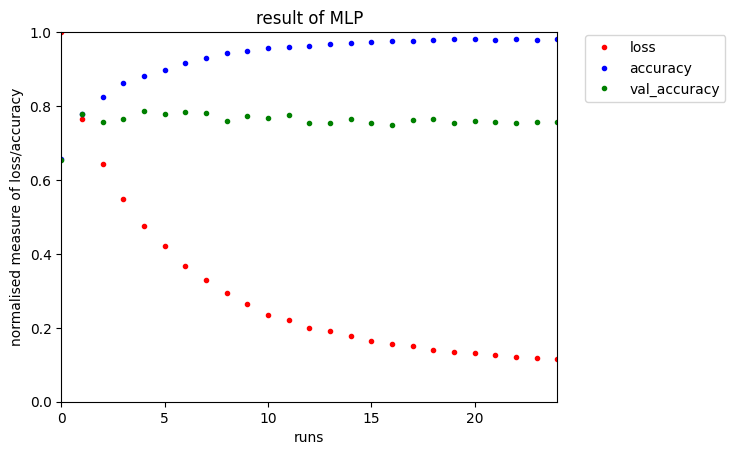

In [115]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show